In [1]:
from astropy.modeling import models, fitting

from scipy.optimize import minimize

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import emcee
import corner
import random
import warnings

from IPython.display import display, Math

warnings.filterwarnings("ignore");

In [4]:
#read in data
lc_c = pd.read_csv('./tables/lc_c.csv',delimiter=',');
#VLBA = pd.read_csv('./VLBA.csv', delimiter=',');
lc_c =  lc_c.iloc[:, 1:-1];
x = np.linspace(lc_c.iloc[0,0], lc_c.iloc[-1,0], num=100);

#get initial model using astropy
p_init = models.BrokenPowerLaw1D(amplitude=2, x_break=19, alpha_1=0.7, alpha_2=-1); ## init power law
fit_p = fitting.LevMarLSQFitter(); ## which fitter to use
p = fit_p(p_init, lc_c.iloc[:,0], lc_c.iloc[:,2], maxiter=10000); ## fit the data

In [5]:
t = lc_c.iloc[:,0].to_numpy(dtype=np.float128);
y = lc_c.iloc[:,2].to_numpy(dtype=np.float128);
yerr = lc_c.iloc[:,3].to_numpy(dtype=np.float128);
x0 = np.linspace(t[0], t[-1], num=100);


In [6]:
def broken_powerlaw(t, t_b, beta_1, beta_2, F_c):
    #Granot & sari 2002
    s = 0.61;    
    a = (t/t_b)**(-s*beta_1);
    b = (t/t_b)**(-s*beta_2);

    F_nu = F_c*(a+b)**(-1/s);
    
    return F_nu

def log_likelihood(theta, t, y, yerr):
    t_b, beta_1, beta_2, F_c = theta;

    model = broken_powerlaw(t, t_b, beta_1, beta_2, F_c);
    
    return -0.5 * np.sum((y - model) ** 2 / yerr + np.log(yerr))

nll = lambda *args: -log_likelihood(*args);

initial = np.array([p.x_break.value, p.alpha_1.value, p.alpha_2.value, p.amplitude.value]);
soln = minimize(nll, initial, args=(t, y, yerr),  method='Nelder-Mead', options={'disp':True, 'maxiter':10000});

t_bml, beta_1ml, beta_2ml, F_cml = soln.x;

print(t_bml, beta_1ml, beta_2ml, F_cml);

t_line = np.linspace(10,500,10000);
newy = broken_powerlaw(t_line, t_bml, beta_1ml, beta_2ml, F_cml);

Optimization terminated successfully.
         Current function value: -20.360831
         Iterations: 295
         Function evaluations: 492
17.326622802099042 -1.5908098504656645 9.325492883689463 5.100127067241401


In [5]:

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta);
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr);


def log_prior(theta):
    t_b, beta_1, beta_2, F_c = theta;
    # print(theta);
    if 16 < t_b < 18.5 and -3 < beta_1 < 0 and 3 < beta_2 < 10.5 and 2 < F_c < 6:
    # if 16 < t_b < 23  and 0 < s < 3 and -3 < beta_1 < 0 and 3 < beta_2 < 13 and 2 < F_c < 6:
        return 0.0
    return -np.inf

In [6]:
pos = soln.x + 0.1*np.random.randn(128, 4);

nwalkers, ndim = pos.shape;

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(t, y, yerr));

sampler.run_mcmc(pos, int(2e5), progress=True);

100%|██████████| 200000/200000 [07:50<00:00, 425.20it/s]


In [7]:
#the walker plots
plt.style.use('default');
# fig, axes = plt.subplots(5, figsize=(20, 7), sharex=True);

samples = sampler.get_chain();

# labels = ["t_b", "beta_1", "beta_2", "F_c"];

labels = ["t_b", "beta_1", "beta_2", "F_c"];
# for i in range(ndim):
#     ax = axes[i]
#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'));
#     ax.plot(samples[:, :, i], "k", alpha=0.2)
#     ax.set_xlim(0, len(samples))
#     ax.set_ylabel(labels[i])
#     ax.yaxis.set_label_coords(-0.1, 0.5)

# axes[-1].set_xlabel("step number");

# plt.savefig(fname='./fits/walker_plot.png', format='png');

In [8]:
tau = sampler.get_autocorr_time();
discard_num = int(tau[0]*2.5);
thin_num = int(tau[0]*0.5);
print(discard_num, thin_num, tau);

154 30 [61.99452454 57.8752919  63.70164131 57.99369386]


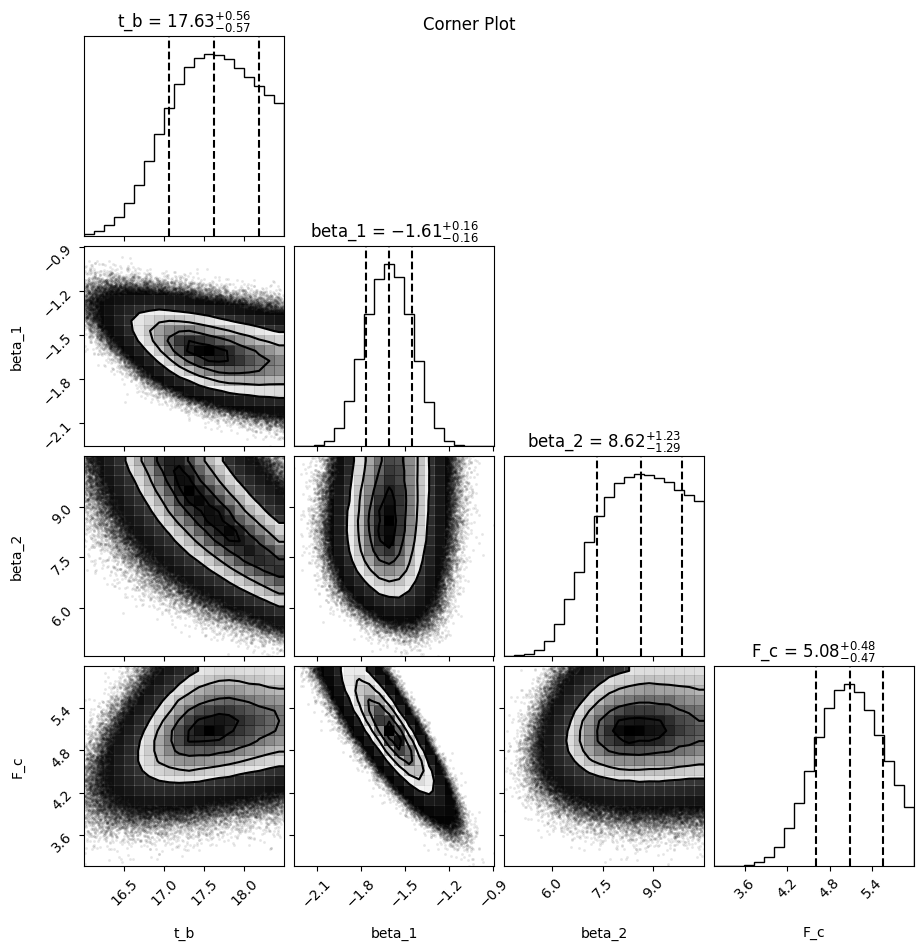

In [9]:
flat_samples = sampler.get_chain(discard=discard_num, thin=thin_num, flat=True);
# flat_samples = sampler.get_chain(discard=664, thin=300, flat=True); 
fig = corner.corner(flat_samples, labels=labels, quantiles=(0.16, 0.5, 0.84), show_titles=True);# plt.title('Corner Plots');
value = np.median(samples, axis=0);
_ = fig.suptitle("Corner Plot")
# corner.overplot_lines(fig, value[0]);
# plt.savefig(fname='./corner_plots.png', format='png');

t_plot = np.linspace(8,500,10000);
# corner.corner.savefig('cornerplot.png')

In [10]:
ndim

4

In [15]:
#the actual forloop to get 16,50,84 percentile
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
#
#
#t_b
mcmc_b = np.percentile(flat_samples[:,0], [10,25,40]);



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

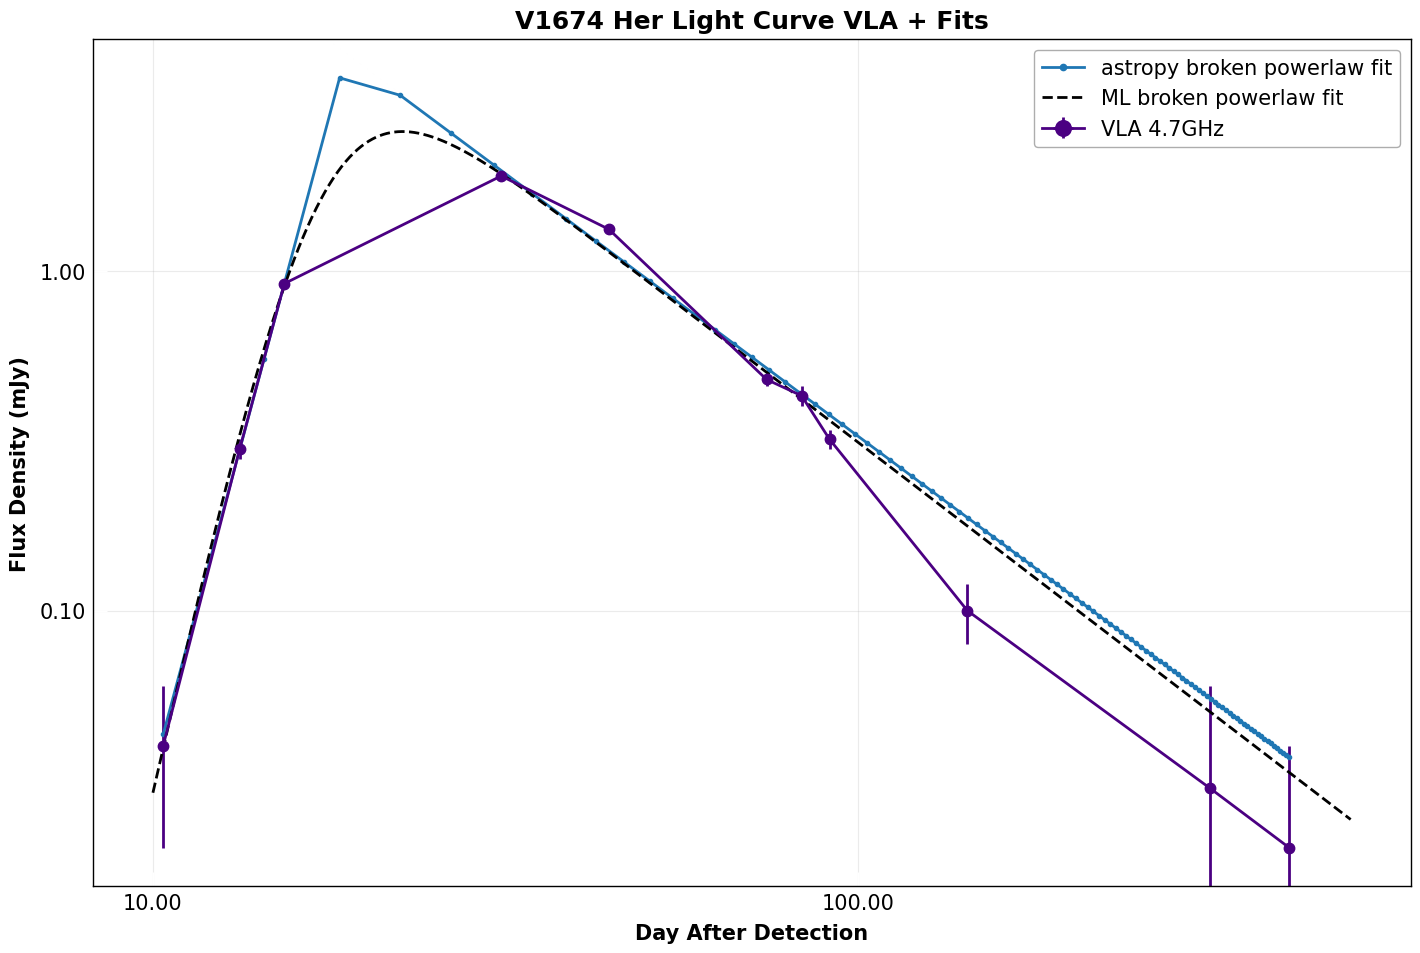

In [12]:
plt.style.use('./light.mplstyle');
fig, ax = plt.subplots(figsize=(17,11), facecolor='white');
plt.rcParams.update({'lines.linewidth':2});
#generate some data
# t_line = np.linspace(10,100,100);
# newy = broken_powerlaw(t_line, t_bml, beta_1ml, beta_2ml, F_cml);
# VLBA_plt = broken_powerlaw(VLBA['Day'], t_bml, beta_1ml, beta_2ml, F_cml);

# newy = broken_powerlaw(t_line, t_bml, s_ml, beta_1ml, beta_2ml, F_cml);
#VLBA_plt = broken_powerlaw(VLBA['Day'], s_ml, t_bml, beta_1ml, beta_2ml, F_cml);

#actual plots
plt.errorbar(t,y,yerr, xerr=0, marker='.', markersize=15, linewidth=2, color='indigo', label='VLA 4.7GHz');
ax.plot(x0, p(x0), marker='.', label='astropy broken powerlaw fit');
ax.plot(t_line, newy, linestyle='dashed', color='k',  label="ML broken powerlaw fit");
#ax.plot(VLBA['Day'], VLBA['Flux'], linestyle='dashed', marker='*', markersize=9, color='crimson');
#ax.scatter(VLBA['Day'], VLBA_plt, label='Guesstimate, using ML', color='red', s=17, marker='x');

#set labels and whatnot
ax.set_title('V1674 Her Light Curve VLA + Fits');
ax.set_ylabel('Flux Density (mJy)');
ax.set_xlabel('Day After Detection');
ax.grid(True, alpha=0.25);

ax.set_xscale('log');
ax.set_yscale('log')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'));
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'));
plt.legend();


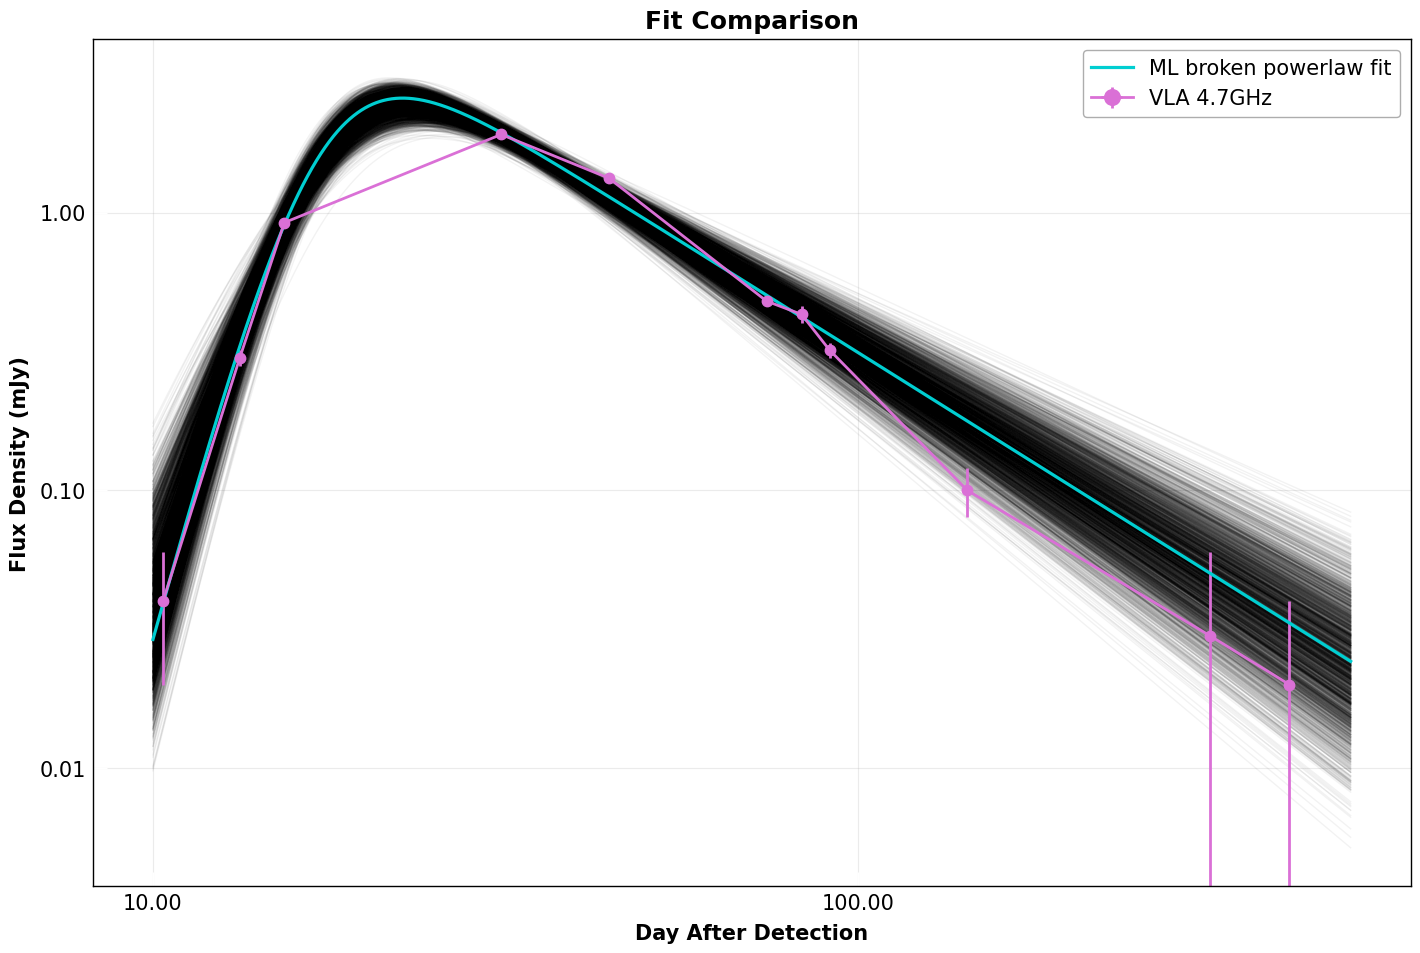

In [14]:
# import random
plt.style.use('./light.mplstyle');

t_plot = np.linspace(10,500,10000);
# fig, ax = plt.figure(figsize=(17,11));
fig, ax = plt.subplots(figsize=(17,11), facecolor='white');

for i in range(2500):
    theta = random.choice(flat_samples)
    t_b, beta_1, beta_2, F_c = theta
    model = broken_powerlaw(t_plot, t_b, beta_1, beta_2, F_c);
    plt.plot(t_plot,model,alpha = 0.05, color = 'black');


plt.grid(True, alpha=0.25);
plt.errorbar(t,y,yerr, xerr=0, marker='.', markersize=15, linewidth=2, color='orchid', label='VLA 4.7GHz');
plt.plot(t_line, newy, color='darkturquoise', linewidth=2.3, label="ML broken powerlaw fit");
plt.title('Fit Comparison');
plt.ylabel('Flux Density (mJy)');
plt.xlabel('Day After Detection');

plt.loglog();
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'));
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'));

plt.savefig(fname='./fit_plots.png', format='png');
plt.legend();

In [ ]:
print(tau);